# PCA

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

#### Read Data

In [2]:
import pandas as pd
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None
)

df_wine.columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315','Proline']
print(df_wine.shape)
df_wine.head()

(178, 14)


,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### Training and Test Features

Process the Wine data into separate training and test datasets:

* 70% training
* 30% testing

In [3]:
X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=0)

#### 1. Standardizing the data

In [4]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

#### 2. Constructing the covariance matrix

From [Numpy's docs](https://numpy.org/doc/stable/reference/generated/numpy.cov.html)

`m` : A 1-D or 2-D array containing multiple variables and observations. Each row of m represents a variable, and each column a single observation of all those variables. [Features, Observations/Samples]

Thus we need to transpose X [Samples, Features]

In [5]:
cov_mat = np.cov(X_train_std.T)
print(cov_mat.shape)

(13, 13)


#### 3. Obtaining the eigenvalues and eigenvectors of the covariance matrix

In [6]:
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

if any(eigen_vals < 0):
    raise ValueError('Negative eigen values')

print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [0.10754642 0.15362835 0.1808613  0.21357215 0.3131368  0.34650377
 0.51828472 0.6620634  0.84166161 0.96120438 1.54845825 2.41602459
 4.84274532]


#### 4. Sorting the eigenvalues by decreasing order to rank the eigenvectors

In [7]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]

cum_var_exp = np.cumsum(var_exp)

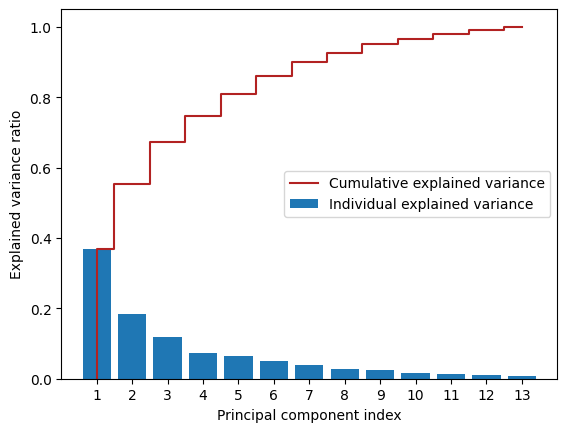

In [8]:
_, ax = plt.subplots()

# Individual Variance
ax.bar(range(1,14), var_exp, align='center', 
        label='Individual explained variance')

# Cumulative Variance
l1 = [0]
l1.extend(cum_var_exp)
ax.step([1] + list(range(1,14)), 
        l1, where='mid', color = 'firebrick',
         label='Cumulative explained variance')


# Graph Aesthetics
ax.set_xlim(0,14)
ax.set_xticks(list(range(1,14,1)))
ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal component index')

ax.legend()
plt.show()

#### 5. Select k eigenvectors based on sorted eigenvalues ( by decreasing order!)

In [9]:
eigen_pairs = [(eigen_vals[i], eigen_vecs[:, i]) 
               for i in range(len(eigen_vals))]

In [10]:
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

#### 6. Construct a projection matrix, W

In [11]:
W = np.hstack([eigen_pairs[0][1].reshape(-1, 1),
               eigen_pairs[1][1].reshape(-1, 1)])

#### 7. Transform the input dataset, X

In [12]:
X_train.shape

(124, 13)

In [13]:
X_train_pca = X_train_std @ W

## Visualization

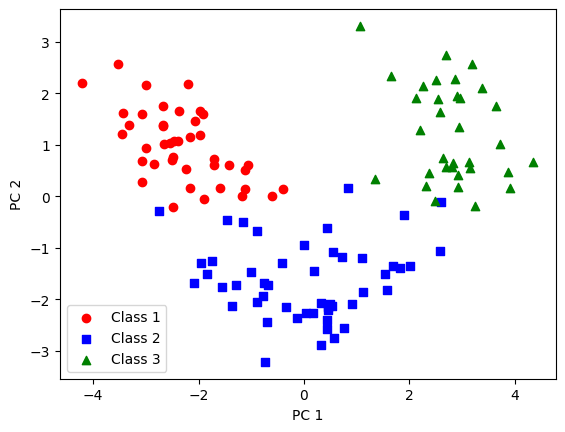

In [14]:
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
_, ax = plt.subplots()
for class_, c, m in zip(np.unique(y_train), colors, markers):
    ax.scatter(X_train_pca[y_train==class_, 0], 
               X_train_pca[y_train==class_, 1],
               c=c, 
               label=f'Class {class_}', marker=m)
    
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')
plt.show()

# PCA with scikit learn

In [24]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    
    _, ax = plt.subplots()    
    ax.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0],
        y=X[y == cl, 1],
        alpha=0.8,
        c=colors[idx],
        marker=markers[idx],
        label=f'Class {cl}',
        edgecolor='black')
        
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend(loc='lower left')
    return ax

In [25]:
# initializing the PCA transformer and
pca = PCA(n_components=2)

In [26]:
# logistic regression estimator:
lr = LogisticRegression(multi_class='ovr',
                        random_state=1,
                        solver='lbfgs')

In [27]:
# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

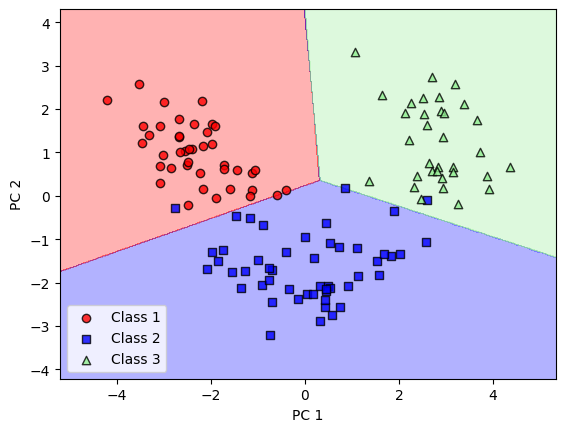

In [28]:
# fitting the logistic regression model on the reduced dataset:

lr.fit(X_train_pca, y_train)
ax = plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.show()